#### Setup PyTorch

In [1]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

# Will still need to manually do `.to(device)` on nn.Module objects and some datasets
torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


#### Load and Prepare Data

In [2]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [3]:
# Index of a character in all characters list
def letter_to_index(letter):
    if letter not in allowed_characters:
        return allowed_characters.find('_')
    else:
        return allowed_characters.find(letter)

# Character-level Encoding
# One-hotting each letter
def line_to_Tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)   # The 1 is because PyTorch expects datasets to be in batches, so each letter here is one batch
    for idx, letter in enumerate(line):
        tensor[idx][0][letter_to_index(letter)]=1
    return tensor

In [4]:
line = 'Work-life balance is for the average.'
line_tensor = line_to_Tensor(line)
line_tensor.sum()

tensor(37.)

In [5]:
line_tensor.argmax(dim=2)[:5]

tensor([[48],
        [14],
        [17],
        [10],
        [57]])

In [6]:
DATA_DIR = 'data/names'

In [7]:
import torch
from torch.utils.data import Dataset
import time
import os

class NameDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir            # For profiling and logs
        self.load_time = time.localtime     # For profiling and logs
        
        self.data = []  # All names
        self.data_tensors = []  # Tensor representations of all names (in order)
        self.labels = []    # All corresponding labels
        self.label_tensors = []     # Tensor representations of labels (Encoded labels)
        self.label_to_index = {}  # Unique labels   # Previous implementation was set(), which runs O(n) instead of the current O(1)

        all_files = os.listdir(data_dir)  # paths of the label folder
        for label_idx, filename in enumerate(all_files):
            current_label = os.path.splitext(filename)[0]
            self.label_to_index[current_label] = label_idx
            filepath = os.path.join(data_dir, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                lines = f.read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.labels.append(current_label)
                self.data_tensors.append(line_to_Tensor(name))
                self.label_tensors.append(torch.tensor([label_idx], dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_tensor = self.data_tensors[idx]
        data_item = self.data[idx]
        label_tensor = self.label_tensors[idx]
        label_name = self.labels[idx]

        return data_tensor, label_tensor, data_item, label_name

In [8]:
name_dataset = NameDataset(DATA_DIR)
name_dataset[0]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]]]),
 tensor([0]),
 'Abl',
 'Czech')

In [9]:
torch.argmax(line_to_Tensor('A'))

tensor(26)

In [10]:
# Split into training and validation sets
train_set, valid_set, test_set = torch.utils.data.random_split(name_dataset, [.70, .15, .15], generator=torch.Generator(device=device).manual_seed(2024))

In [11]:
len(train_set), len(valid_set)

(14052, 3011)

In [13]:
import torch.nn as nn
import torch.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,    # We ignore `output_size` because we don't need output for this layer
            )
        self.output_layer = nn.Linear(
            in_features=hidden_size,
            out_features=output_size,
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, rnn_hidden = self.rnn(line_tensor)
        output = self.output_layer(rnn_hidden)
        output = self.softmax(output)

        return output

In [14]:
n_hidden = 128
rnn_model = CharRNN(n_letters, n_hidden, len(set(name_dataset.labels)))

In [15]:
rnn_model

CharRNN(
  (rnn): RNN(58, 128)
  (output_layer): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [16]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = line_to_Tensor('Albert')
output = rnn_model(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, list(set(name_dataset.labels))))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<LogSoftmaxBackward0>)
('German', 0)


#### Training Loop
**This code piece is a not based on standard-practices as we do a lot of things from scratch using plain Python.**

In [ ]:
import random
import numpy as np

def fit(model, training_data, n_epochs=10, n_batch_size=128, report_every=50, learning_rate=0.2, criteria=nn.NLLLoss()):
    
    # Variable to keep track of (for plotting etc)
    all_losses = []
    current_loss = 0
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(1, n_epochs+1):
        model.zero_grad()   # This is an old and bad practice, `optimizer.zero_grad()` is enough and preferred.

        # Create mini-batches
        # We are not using DataLoader because all sequences are of different legnths
        batches = list(range(len(train_set)))   # A list [0, 1, 2 ... size of training set]
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches)/n_batch_size) # batches indexes
        
        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #each example in the current batch
                (x, y, name, label) = train_set[i]
                y_pred = model.forward(x).reshape([1,18]) # because the output of an RNN model is in shape [num_layers, batch_size, num_classes] (i.e. [1,1,18] here.)
                #print(y_pred.shape)
                #print(y.shape)
                loss = criteria(y_pred, y)  # NLLLoss expects `y_pred` as [batch_size, num_classes] with probas, but `y` as [batch_size] with class label
                batch_loss += loss
            
            # Optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() # average loss of the batch

        all_losses.append(current_loss/len(batches)) # average losses of each batch
        if epoch % report_every == 0:
            print(f"{epoch} ({epoch / n_epochs:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses


In [66]:
import time

start = time.time()
all_losses = fit(rnn_model, train_set, n_epochs=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

5 (19%): 	 average batch loss = 0.0
10 (37%): 	 average batch loss = 0.0
15 (56%): 	 average batch loss = 0.0
20 (74%): 	 average batch loss = 0.0
25 (93%): 	 average batch loss = 0.0
training took 96.76521182060242s


**Will fix this later**

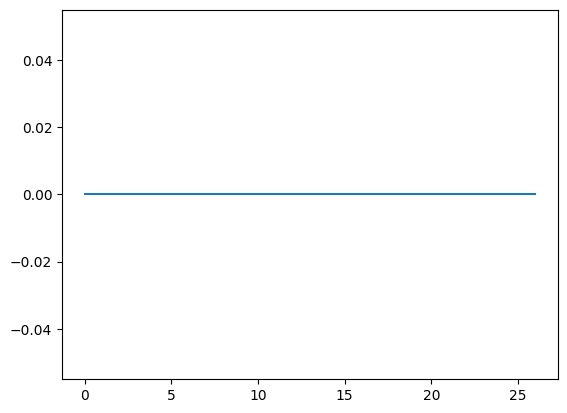

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

#### A more PyTorch friendly way
**As per standard industry practices for RNNs**